## Chainer チュートリアル　復習
http://docs.chainer.org/en/stable/tutorial/basic.html#core-concept

In [65]:
# 必要なパッケージのインポート

import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions

In [66]:
# numpy array から Variable オブジェクトの生成

x_data = np.array([5], dtype=np.float32)
x = Variable(x_data)

In [67]:
# variable オブジェクトは基本的な演算に対応

y = x**2 - 2*x + 1
y.data

array([ 16.], dtype=float32)

In [68]:
# variable オブジェクトは 値だけでなく，　計算履歴（or 計算グラフ）も保持
# →　微分，逆伝播が計算可能 (計算グラフの chain rule を参照)

y.backward()

# →　x.grad に勾配が計算されて格納される
x.grad

array([ 8.], dtype=float32)

In [69]:
# retain_grad オプションを指定することで 中間での 勾配も保持
z = 2*x
y = x**2 - z + 1

y.backward(retain_grad=True)
z.grad

array([-1.], dtype=float32)

In [ ]:
# 多次元配列についての計算も可能， backward はどうなる？？
# 多次元配列から逆伝播計算を始める場合は，初期誤差?を手動で設定しなければなりません？

x = Variable(np.array([[1,2,3],[4,5,6]], dtype=np.float32))
y = x**2 -2*x + 1

y.grad = np.ones((2,3), dtype=np.float32)
y.backward()
x.grad

## Links

In [70]:
# 線形結合リンク関数　Linear →　y = w*x +b の w,b をパラメータとしてもつ
# リンク関数はミニバッチのみを入力として受け取る N×３　行列 ( 最初の次元のN がミニバッチの大きさ)

f =L.Linear(3,2)

In [71]:
# リンクのパラメータは Variable 形式のインスタンスとして格納されている

# Wの初期値は乱数， bの初期値は 0
print(f.W.data)
print(f.b.data)

[[-0.12613261 -0.20426658 -0.17101675]
 [ 1.40129125 -0.70833069  0.15234466]]
[ 0.  0.]


In [72]:
x = Variable(np.array([[1,2,3],[4,5,6]], dtype=np.float32))
y = f(x)
y.data

array([[-1.04771602,  0.44166386],
       [-2.55196381,  2.97757959]], dtype=float32)

In [73]:
# 勾配は .backward() メソッドで計算できるが，毎回蓄積されるので，計算を新しくする場合は
# .cleargrads()をする必要がある

f.cleargrads()

In [75]:
y.grad = np.ones((2,2), dtype=np.float32)
y.backward()

print(f.W.grad)
print(f.b.grad)


[[ 10.  14.  18.]
 [ 10.  14.  18.]]
[ 4.  4.]


## Write a model as a chain

In [76]:
# リンクを組合せて多層化する

l1 = L.Linear(4,3)
l2 = L.Linear(3,2)

def my_forward(x):
    h = l1(x)
    return l2(h)

In [77]:
#  パラメータ等の変更,保存,GPU 等の使用も可能にするため，  Chain クラスを継承
# 更にこの Mychain クラスを小リンクとしたリンクも作成可能

class MyChain(Chain):
    def __init__(self):
        
        # super は継承した親クラスのインスタンスメソッドを呼び出すのに使う
        # Chain クラスの 初期化方法を用いる
        super(MyChain, self).__init__(
            l1 = L.Linear(4,3),
            l2 = L.Linear(3,2),
        )
        
    def __call__(self, x):
        h = self.l1(x)
        return self.l2(h)

## Optimizer

In [78]:
# Optimizer には沢山の数値最適化アルゴリズムが実装されている
# SGDを用いて最適化してみる

model = MyChain()
optimizer = optimizers.SGD()

optimizer.use_cleargrads() # 効率化のため？　詳細はメソッドの説明を
optimizer.setup(model) # モデルに対する optimizer の設定

# 重み減衰等の設定は .add_hook で設定可能
# 勾配を計算した後に，パラメータを更新する前に用いられる
# 自分でも optimizer を変数として取る hook 関数を作成可能

optimizer.add_hook(chainer.optimizer.WeightDecay(0.0005))

In [59]:
# Optimizer を用いる方法として Trainer を用いる方法と　直接用いる方法がある

# 直接用いる方法も２通り　

# １．手動で勾配を計算して， update() を引数無しで用いる

x = np.random.uniform(-1, 1, (2, 4)).astype('f')
model.cleargrads()

# Chainer の F　クラスは何をしているのか？？
loss = F.sum(model(chainer.Variable(x)))
loss.backward()
optimizer.update()

In [60]:
# 2. loss 関数を update() メソッドに渡す
# 　　　　この場合は cleargrads() は update（） の中で自動的に呼ばれる

def lossfun(arg1, arg2):
    
    loss = F.sum(model(arg1 - arg2))
    return loss

arg1 = np.random.uniform(-1, 1, (2, 4)).astype('f')
arg2 = np.random.uniform(-1, 1, (2, 4)).astype('f')
optimizer.update(lossfun, chainer.Variable(arg1), chainer.Variable(arg2))

# Trainer

1. Iterations over training datasets
2. Preprocessing of extracted mini-batches
3. Forward/backward computations of the neural networks
4. Parameter updates
5. Evaluations of the current parameters on validation datasets
6. Logging and printing of the intermediate results


*Dataset abstraction.* 
 - It implements 1 and 2 in the above list. The core components are defined in the dataset module. There are also many implementations of datasets and iterators in datasets and iterators modules, respectively.

*Trainer*.
- It implements 3, 4, 5, and 6 in the above list. The whole procedure is implemented by Trainer. The way to update parameters (3 and 4) is defined by Updater, which can be freely customized. 5 and 6 are implemented by instances of Extension, which appends an extra procedure to the training loop. Users can freely customize the training procedure by adding extensions. Users can also implement their own extensions.

## Serializer

## Example: Multi-layer Perceptron on MNIST

In [79]:
train, test = datasets.get_mnist()

In [79]:
# 分類のための 多層パーセプトロンを定義

class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__(
            
            # それぞれのレイヤーへの入力のサイズは推定される
            l1= L.Linear(None, n_units),
            l2= L.Linear(None, n_units),
            l3 = L.Linear(None, n_out) ,
        )
        
    def __call__(self,x):
        
        # ユニットの活性化関数として relu を使用
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        
        return y

In [80]:
# 学習したモデルを用いて　予測誤差，　予測精度の算出を行うクラスを用意

class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__(predictor=predictor)
        
    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        
        # loss と　accuracy 値 を Trainer へ渡す　詳しくは Reporter のページ参照
        report({'loss': loss, 'accuracy': accuracy}, self)
        return loss

In [81]:
#


model = L.Classifier(MLP(100,10)) #MNIST 入力画像の 784 次元はデータから自動的に取得
optimizer = optimizers.SGD()
optimizer.setup(model)

In [82]:
# Train loop 毎に用いるバッチサイズ， 用いる順番をシャッフルするか指定
train_iter = iterators.SerialIterator(train, batch_size=100, shuffle=True)

# Training の際の バッチの与え方， Optimizer の指定
updater = training.StandardUpdater(train_iter, optimizer)

In [83]:
trainer   = training.Trainer(updater, (20, 'epoch'), out='result')

In [1]:
test_iter = iterators.SerialIterator(test, batch_size=100, shuffle=True)

trainer.extend(extensions.Evaluator(test_iter, model))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy']))
trainer.extend(extensions.ProgressBar())
trainer.run()  


NameError: name 'iterators' is not defined

# 少し古い版の Trainer を用いない方法

http://qiita.com/kenmatsu4/items/7b8d24d4c5144a686412

In [80]:
## MNIST のデータを取得

from sklearn.datasets import fetch_mldata

print("fetch MNIST dataset")
mnist = fetch_mldata('MNIST original', data_home=".") # 取得して data_home のディレクトリに保存

fetch MNIST dataset


In [81]:

# mnist データを float32 形式にし 0~1 の値へと正規化
# 784次元 70000件のベクトルデータ

mnist["data"] = mnist["data"].astype(np.float32)
mnist["data"] = mnist['data'] / 255

# 各データの正解ラベル（0~9）
# soft max crossentropy では int32でないといけない？
mnist['target'] = mnist['target'].astype(np.int32)


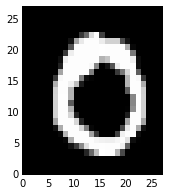

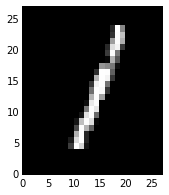

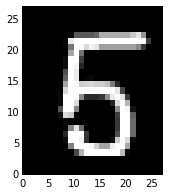

In [82]:
# 手書き数字データを描画する関数

import matplotlib.pyplot as plt
%matplotlib inline

def draw_digit(data):
    size = 28
    plt.figure(figsize=(2.5, 3))

    X, Y = np.meshgrid(range(size),range(size))
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(X, Y, Z)
    #plt.gray()
    #plt.tick_params(labelbottom="off")
    #plt.tick_params(labelleft="off")

    plt.show()

draw_digit(mnist.data[5])
draw_digit(mnist.data[12345])
draw_digit(mnist.data[33456])

In [83]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist["data"], mnist["target"],\
                                                    test_size = 0.3, random_state=0)

In [84]:
# 分類のための 多層パーセプトロンを定義

class MLP(Chain):
    def __init__(self):
        super(MLP, self).__init__(
            
            l1= L.Linear(784, 100),
            l2= L.Linear(100, 100),
            l3 = L.Linear(100, 10) ,
        )
        
    def __call__(self,x):
        
        # ユニットの活性化関数として relu を使用
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        
        return y

In [85]:
model = L.Classifier(MLP()) 
optimizer = optimizers.SGD()
optimizer.setup(model)

epoch 0
train mean loss=0.245480781041, accuracy=1.35881632871
test mean loss=0.183325314522, accuracy=0.94757143032
epoch 1
train mean loss=0.239274762951, accuracy=1.36044898167
test mean loss=0.180503037199, accuracy=0.947904766457
epoch 2
train mean loss=0.233706513078, accuracy=1.36200000522
test mean loss=0.17664874526, accuracy=0.949333332834
epoch 3
train mean loss=0.227637403671, accuracy=1.3636938814
test mean loss=0.172698568588, accuracy=0.94976190584
epoch 4
train mean loss=0.222047951498, accuracy=1.36536735041
test mean loss=0.168749432727, accuracy=0.951714287769
epoch 5
train mean loss=0.216407198409, accuracy=1.36689796253
test mean loss=0.167534174451, accuracy=0.950857145446
epoch 6
train mean loss=0.212102907839, accuracy=1.36767347443
test mean loss=0.164045777793, accuracy=0.952095239219
epoch 7
train mean loss=0.207107891207, accuracy=1.3696122515
test mean loss=0.159782994858, accuracy=0.952761908088
epoch 8
train mean loss=0.20194450055, accuracy=1.37083674207

[]

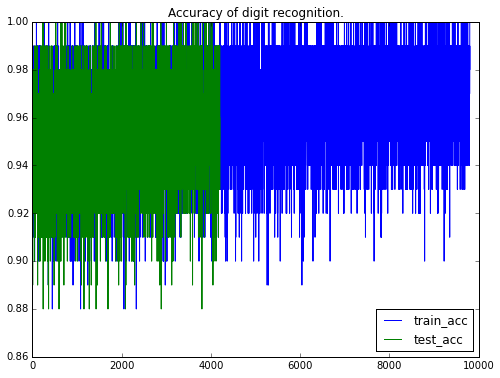

In [52]:
#学習ループの作成，　学習の実行

batchsize = 100
datasize = X_train.shape[0]
test_datasize = X_test.shape[0]

train_loss = []
train_acc = []
test_loss = []
test_acc = []

l1_W = []
l2_W = []
l3_W = []

for epoch in range(20):
    print('epoch %d' % epoch)
    
    # エポック毎にシャッフルしてから順にバッチを作成　→　学習
    indexes = np.random.permutation(datasize)
    
    for i in range(0, datasize, batchsize):
        x = Variable(X_train[indexes[i : i+batchsize]])
        t = Variable(y_train[indexes[i : i+batchsize]])
        
        # 勾配を初期化
        model.cleargrads()
        
        # 順伝播を計算,
        loss = model(x, t) # LossFunction は Classifier によって定義されている，デフォルトで ソフマ？
        loss.backward()
        optimizer.update()
        
        train_loss.append(model.loss.data)
        train_acc.append(model.accuracy.data)
        sum_loss          += float(model.loss.data)*batchsize
        sum_accuracy += float(model.accuracy.data)*batchsize
        
    # 訓練データの誤差と，正解精度を表示
    print 'train mean loss={}, accuracy={}'.format(sum_loss/datasize, sum_accuracy/datasize)
    
    
    # evaluation エポック毎に学習した結果をテストデータに対して評価，汎化性能を確認
    sum_accuracy = 0
    sum_loss = 0
    indexes = np.random.permutation(test_datasize)
    
    for i in range(0,  test_datasize, batchsize):
        x = Variable(X_test[indexes[i:i+batchsize]])
        t = Variable(y_test[indexes[i:i+batchsize]])
        
        # 順伝搬させて誤差と精度を算出
        loss = model(x, t)
        
        test_loss.append(model.loss.data)
        test_acc.append(model.accuracy.data)
        sum_loss          += float(model.loss.data)*batchsize
        sum_accuracy += float(model.accuracy.data)*batchsize
        
    print 'test mean loss={}, accuracy={}'.format(sum_loss/test_datasize, sum_accuracy/test_datasize)
    
    l1_W.append(model.predictor.l1.W)
    l2_W.append(model.predictor.l2.W)
    l3_W.append(model.predictor.l3.W)
   

# 精度と誤差をグラフ描画
plt.figure(figsize=(8,6))
plt.plot(range(len(train_acc)), train_acc)
plt.plot(range(len(test_acc)), test_acc)
plt.legend(["train_acc","test_acc"],loc=4)
plt.title("Accuracy of digit recognition.")
plt.plot()

In [63]:
np.shape(l1_W[1].data)

l1_W[19].data

array([[-0.03208002,  0.02585791,  0.01678327, ...,  0.02804999,
        -0.04942786, -0.04374402],
       [ 0.04275535,  0.02484579,  0.05725823, ..., -0.02044093,
         0.0009794 , -0.02484945],
       [ 0.00053674,  0.0731164 ,  0.01530284, ..., -0.0012989 ,
         0.02629014,  0.00952125],
       ..., 
       [-0.06403632, -0.0229362 , -0.00621106, ..., -0.05277801,
        -0.05946614,  0.0354282 ],
       [ 0.02588413,  0.03139373,  0.01971174, ..., -0.01865957,
         0.06374613, -0.03902087],
       [ 0.02321671,  0.00978202, -0.00684102, ..., -0.00208699,
        -0.02405473,  0.06309076]], dtype=float32)

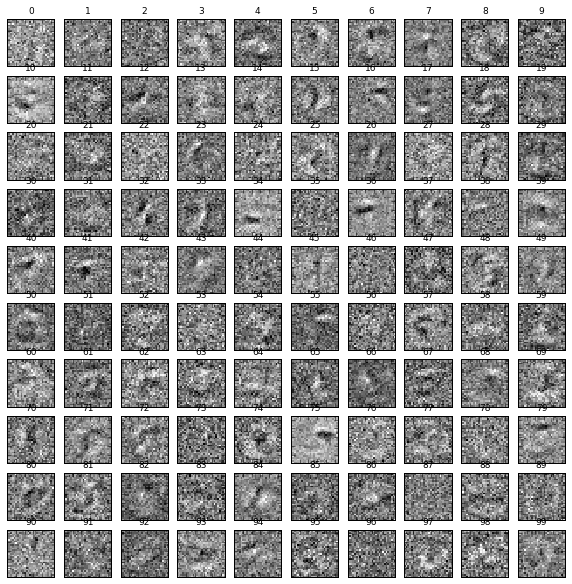

In [64]:
## 第一層の重みを可視化
def draw_digit2(data, n, i):
    size = 28
    plt.subplot(10, 10, n)
    Z = data.reshape(size,size)   # convert from vector to 28x28 matrix
    Z = Z[::-1,:]             # flip vertical
    plt.xlim(0,27)
    plt.ylim(0,27)
    plt.pcolor(Z)
    plt.title("%d"%i, size=9)
    plt.gray()
    plt.tick_params(labelbottom="off")
    plt.tick_params(labelleft="off")

plt.figure(figsize=(10,10))
cnt = 1
for i in range(100):
    draw_digit2(l1_W[len(l1_W)-1].data[i], cnt, i)
    cnt += 1

plt.show()

In [41]:
# テストデータに対して学習結果を確認

sum_loss, sum_accuracy = 0, 0
for i in range(0, 10000, batchsize):
    x = Variable(X_test[i : i + batchsize])
    t = Variable(y_test[i : i + batchsize])
   
    # 順伝播を計算
    loss = model(x, t)
    sum_loss          += model.loss.data * batchsize
    sum_accuracy += model.accuracy.data * batchsize # Classifier のメソッドで accuracy が存在
    
mean_loss = sum_loss / 10000
mean_accuracy = sum_accuracy / 10000

In [42]:
mean_loss

2.3244999718666075

In [43]:
mean_accuracy

0.09539999959990382

In [18]:
# Classifier を 用いない場合の 予測誤差の算出方法

model = MLP()
pred = model(Variable(X_train))
loss = F.softmax_cross_entropy(pred, y_train)
loss.data

array(2.3038229942321777, dtype=float32)

In [19]:
# Classifier を 用いいた場合の　予測誤差の算出方法

model = L.Classifier(MLP())
loss = model(Variable(X_train), y_train)
loss.data

array(2.308255910873413, dtype=float32)